# Scraping Summary Data of FIFA World Cup History from Wikipedia

The FIFA World Cup, often simply called the World Cup, is an international association football competition contested by the senior men's national teams of the members of the Fédération Internationale de Football Association (FIFA), the sport's global governing body. The tournament has been held every four years since the inaugural tournament in 1930, except in 1942 and 1946 when it was not held because of the Second World War. The reigning champions are Argentina, who won their third title at the 2022 tournament (From Wikipedia).

**The history of the World Cup provides interesting data for analytics, however, getting the entire data can be challenging. This Notebook describes how to scrape Wikipedia for the world cup history data from 1930 to 2022**

### Let's Begin.....

There are two main datasets:
 - The summary data for each world cup year
 - The data on every match that has been played

### 1. Scraping the Summary of Each World Cup Year

At Wikipedia, information about each world cup tournament can be found at **"https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup"** (see link circled in red in figure below) and summary data can be located in the infobox circled in green in the figure below. 

At the infobox, we can grab details such as the Host country, Dates, Number of Teams, Champions etc.. 

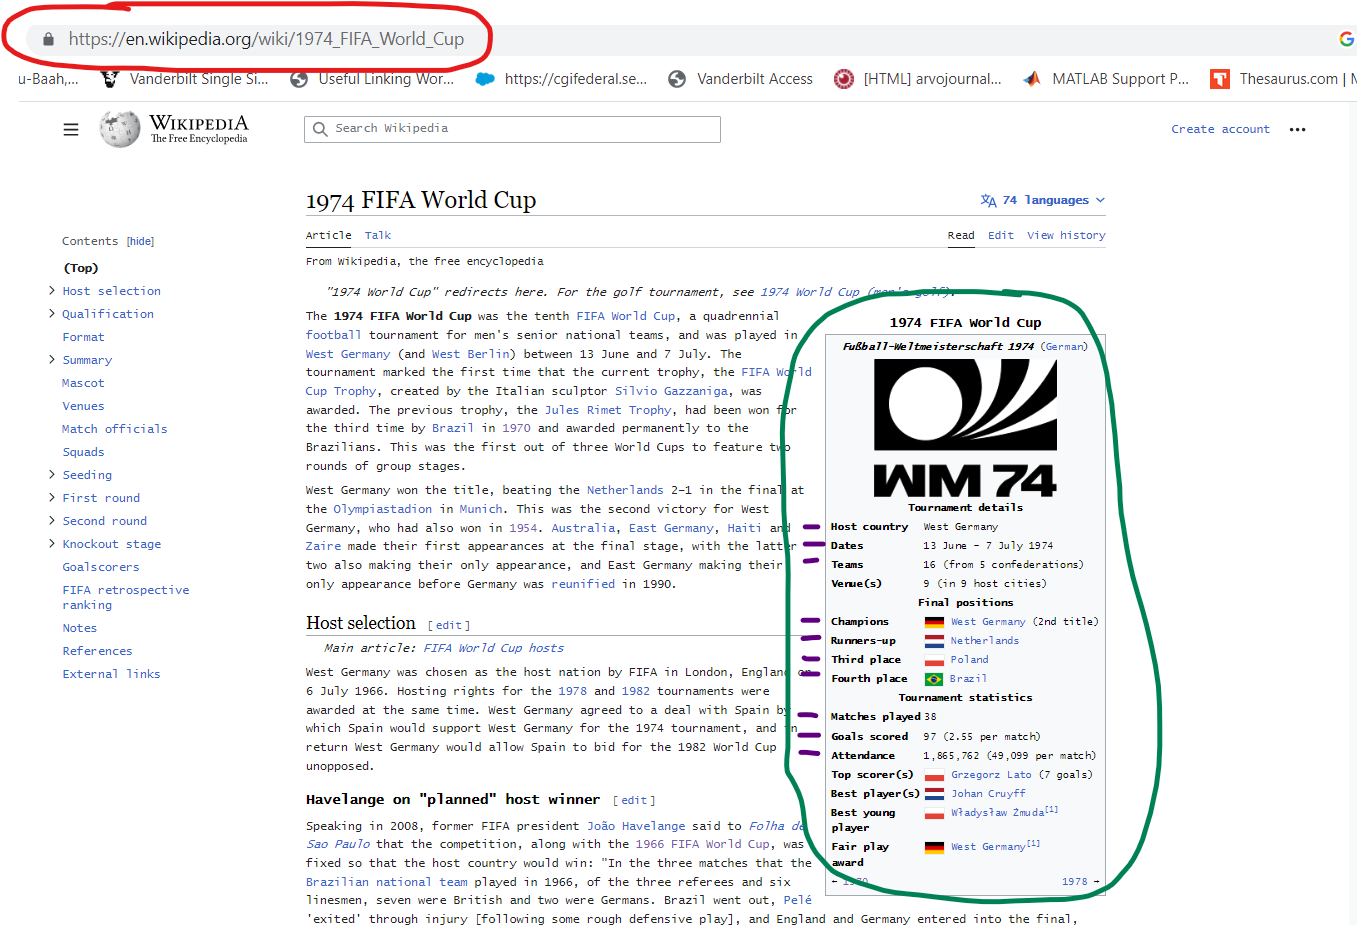

To get the information from this website, we will use python libraries **requests** to get the content and **beautifulsoup** to parse the content; numpy and pandas will be used for manipulating numerical and table-like data. I found unicodedata.normalize to be very useful in getting text from scraped data. 

You can install the libraries using the following lines of code
 - pip install requests
 - pip install beautifulsoup4

After installing we will import the libraries...

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from unicodedata import normalize

We will use request to get content and use beautifulsoup to parse contents 

In [2]:
year = 1974
r = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup')
soup = BeautifulSoup(r.text, 'html.parser')

#### Now, how do we get the dat from the parsed information. At Wikipedia, the summary history data is located at the **infobox** in the figure below and tagged with ***table.infobox.vcalendar***. We will use the tag to extract that data from the parsed information

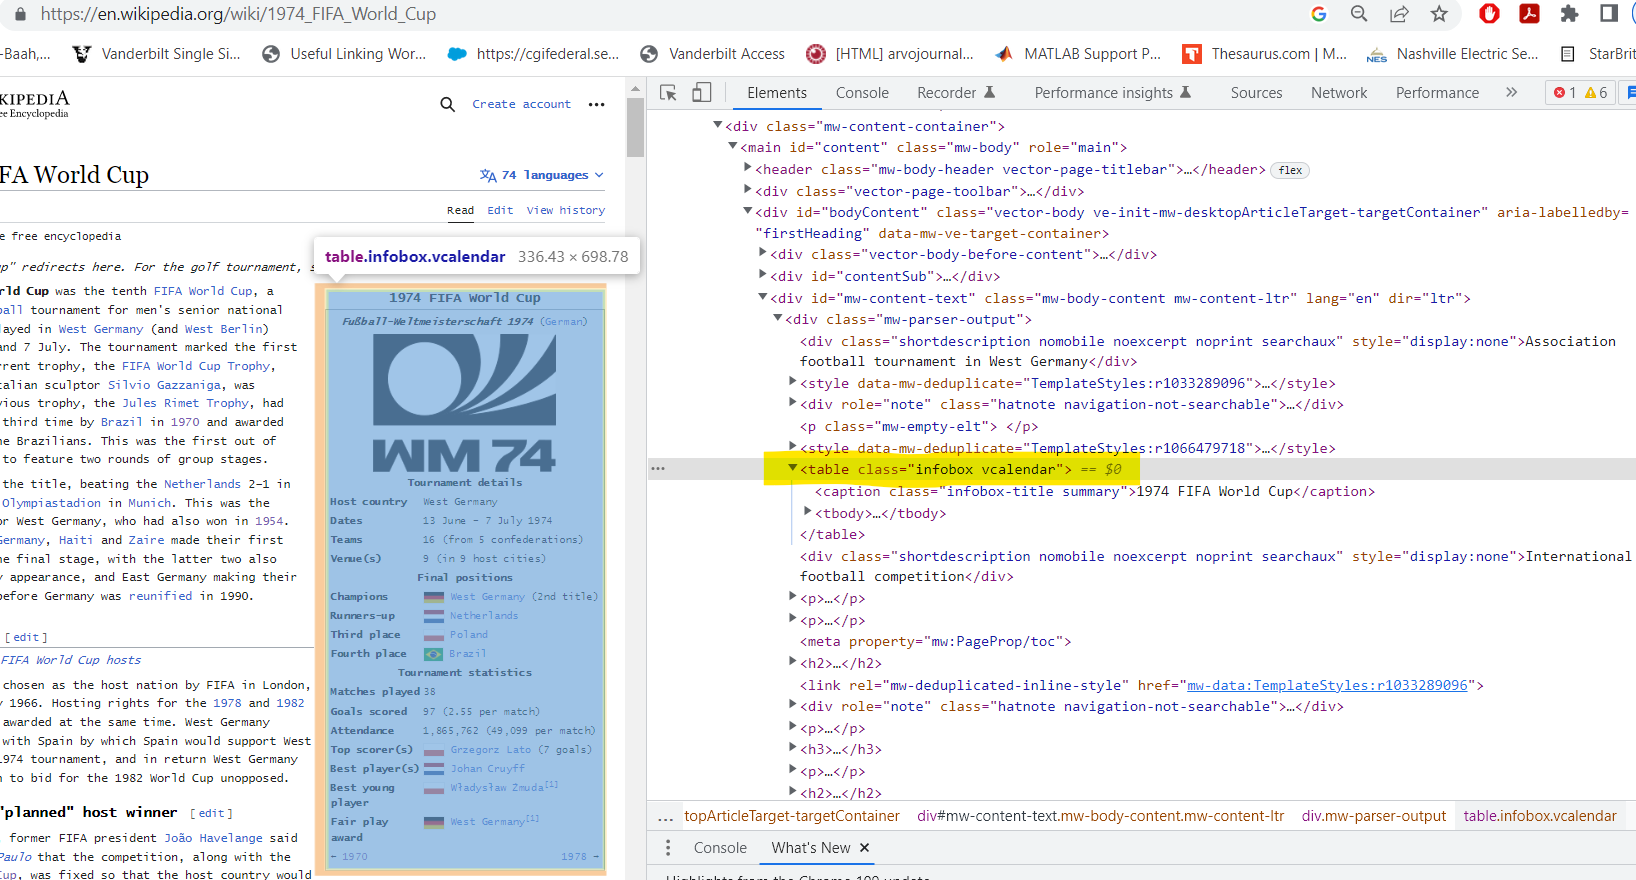

In [3]:
summary = soup.find_all('table', {"class": "infobox vcalendar"})

#### Having extracted the infobox data, we can then extract each of the information we want such as Host country, Dates, Teams etc. These information are tagged with "tr", under which there are the "th.infobox-label" for the heading such as Host country and td.infobox-data for the label such as West Germany. See figure below

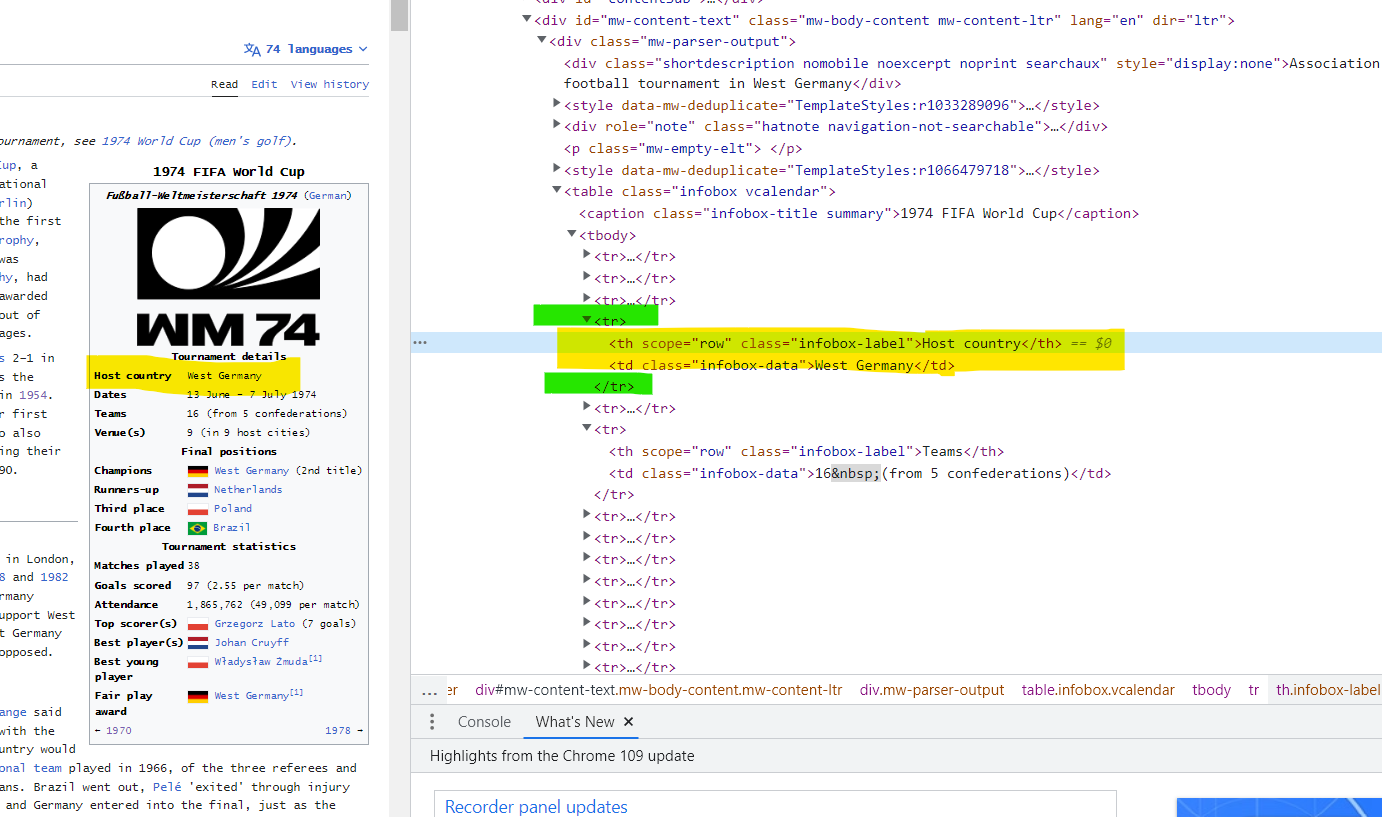

### We can then find all data with the tag 'tr' and iterate through them to find the headings and labels

In [4]:
sum_contents = summary[0].find_all('tr')

create an empty data frame with desired columns to append data

In [5]:
cols = ['Host country', 'Dates', 'Teams', 'Champions', 'Runners-up',
         'Third place', 'Fourth place', 'Matches played', 'Goals scored',
         'Attendance']
cupsummary = pd.DataFrame(columns = cols)
cupsummary.head()

,Host country,Dates,Teams,Champions,Runners-up,Third place,Fourth place,Matches played,Goals scored,Attendance


created this function **find_delimiter** to take a string and determine whether certain delimiters are present. 
The delimiters are those found in the scraped data and will help in cleaning the data





In [6]:
def find_delimiter(string):
    dts = [' (', '[']
    n = 0
    run = 1
    while run and n < len(dts):
        if string.find(dts[n]) == -1:
            run = 1
            n += 1
            delimiter = 'None'
        else:
            run = 0
            delimiter = dts[n]
    return delimiter

Now for each row, determine whether it contains the information in the columns of the dataframe. if yes, clean the text and append it to the datasets 

In [7]:
for eachrow in sum_contents:
    gettext = eachrow.find('th', {'class': 'infobox-label', 'scope':'row'})

    if gettext is not None:

        heading = normalize('NFKD', gettext.text)

        if heading in cols:
            label = normalize('NFKD', eachrow.find('td').text)
            delimiter = find_delimiter(label)
            if delimiter != 'None':
                label = label.split(delimiter)[0]
            cupsummary.loc[0, heading] = label

cupsummary.head()

,Host country,Dates,Teams,Champions,Runners-up,Third place,Fourth place,Matches played,Goals scored,Attendance
0,West Germany,13 June – 7 July 1974,16,West Germany,Netherlands,Poland,Brazil,38,97,"1,865,762"


#### We can put everything together and get the history data for all the years from 1930 to 2022



In [8]:
# list the years of world cup that need to be scraped 
worldcup = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982,
            1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]

cols = ['Host country', 'Year', 'Dates', 'Teams', 'Champions', 'Runners-up',
         'Third place', 'Fourth place', 'Matches played', 'Goals scored',
         'Attendance']
cupsummary = pd.DataFrame(columns = cols)

# for each year of world cup
for i, year in enumerate(worldcup):
    
    # append world cup year
    cupsummary.loc[i, 'Year'] = year
    
    # use request to get content and use beautifulsoup to parse contents
    r = requests.get(f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup')
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # we want the table with the tag: "class: infobox vcalendar"
    summary = soup.find_all('table', {"class": "infobox vcalendar"})
    
    # find contents with tag "tr"
    sum_contents = summary[0].find_all('tr')
    
    # for each row, determine whether it contains the information in the columns of the dataframe
    # if yes, clean the text and append it to the datasets 
    for eachrow in sum_contents:
        gettext = eachrow.find('th', {'class': 'infobox-label', 'scope':'row'})
        
        if gettext is not None:
        
            heading = normalize('NFKD', gettext.text)
            
            if heading in cols or heading == 'Host countries':
                
                label = normalize('NFKD', eachrow.find('td').text)
                delimiter = find_delimiter(label)
                
                if heading not in ['Host countries', 'Dates']:
                    if delimiter != 'None':
                        label = label.split(delimiter)[0]
                else:
                    if heading == 'Host countries':
                        heading = 'Host country'
                cupsummary.loc[i, heading] = label
                
               
                

### view complete dataframe

In [9]:
cupsummary

,Host country,Year,Dates,Teams,Champions,Runners-up,Third place,Fourth place,Matches played,Goals scored,Attendance
0,Uruguay,1930,13–30 July 1930,13,Uruguay,Argentina,United States,Yugoslavia,18,70,"590,549"
1,Italy,1934,27 May – 10 June 1934,16,Italy,Czechoslovakia,Germany,Austria,17,70,"363,000"
2,France,1938,4–19 June 1938,15,Italy,Hungary,Brazil,Sweden,18,84,"374,835"
3,Brazil,1950,24 June – 16 July 1950,13,Uruguay,Brazil,Sweden,Spain,22,88,"1,045,246"
4,Switzerland,1954,16 June – 4 July 1954,16,West Germany,Hungary,Austria,Uruguay,26,140,"768,607"
5,Sweden,1958,8–29 June 1958,16,Brazil,Sweden,France,West Germany,35,126,"819,810"
6,Chile,1962,30 May – 17 June 1962,16,Brazil,Czechoslovakia,Chile,Yugoslavia,32,89,"893,172"
7,England,1966,11–30 July 1966,16,England,West Germany,Portugal,Soviet Union,32,89,"1,563,135"
8,Mexico,1970,31 May – 21 June 1970,16,Brazil,Italy,West Germany,Uruguay,32,95,"1,604,065"
9,West Germany,1974,13 June – 7 July 1974,16,West Germany,Netherlands,Poland,Brazil,38,97,"1,865,762"


#### save dataframe into csv file

In [10]:
cupsummary.to_csv('WorldCupSummaryData.csv')